Dans ce notebook, nous avons créé un moteur de recherche qui parcourt la collection de questions StackOverFlow Python et récupère les questions et les tags les plus similaires à la question d'entrée

In [1]:
from IPython.core.display import display
!pip install transformers

In [2]:
!pip install simpletransformers==0.32.3

In [3]:
!pip install wordcloud

In [4]:
!pip install torch
~

In [5]:
import pandas as pd
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud , STOPWORDS
import matplotlib.pyplot as plt
from transformers import (GPT2Config,GPT2LMHeadModel,GPT2Tokenizer)
from tqdm.notebook import tqdm
import torch

pd.set_option('display.max_colwidth', -1)

<ipython-input-5-94594e12e4a8>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedecabre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
questions = pd.read_csv("input/Questions.csv", encoding = "ISO-8859-1")
print(len(questions))
display(questions.head(5))

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'],
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=1000
                          )
print(len(df_questions))
display(df_questions.head(5))

607282


,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from its display name on a Mac?,"<p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>\n\n<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>\n\n<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>\n\n<ul>\n<li>Some Photoshop javascript</li>\n<li>A Python function</li>\n<li>An OSX API that I can call from python</li>\n</ul>\n"
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,"<p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>\n\n<p>On the Mac I am spawning <a href=""http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html"">sips</a>. Is there something similarly simple I can do on Windows?</p>\n"
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Codebase,"<p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending nag e-mails to responsible persons when the tests fail) similar to CruiseControl or TeamCity.</p>\n\n<p>I realize I could do this with hooks in most VCSes, but that requires that the tests run on the same machine as the version control server, which isn't as elegant as I would like. Does anyone have any suggestions for a small, user-friendly, open-source continuous integration system suitable for a Python codebase?</p>\n"
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a result set. What are the tradeoff of each?</p>\n
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python objects in an array,"<p>I don't remember whether I was dreaming or not but I seem to recall there being a function which allowed something like,</p>\r\n\r\n<pre><code>foo in iter_attr(array of python objects, attribute name)</code></pre>\r\n\r\n<p>I've looked over the docs but this kind of thing doesn't fall under any obvious listed headers</p>"


990


,Id,Score,Body,Title,Text
0,4,718,"use change form ' code : trans = 5000 ; this.opacity = trans ; build application , give follow error : can not implicitly type decimal try use trans , control code work vb.net project .",convert decimal # ?,"convert decimal # ? use change form ' code : trans = 5000 ; this.opacity = trans ; build application , give follow error : can not implicitly type decimal try use trans , control code work vb.net project ."
1,6,305,"absolutely position div contain child , one relatively position use width child div , collapse ie7 , firefox safari . use pixel width , parent relatively position , percentage width child work . something miss ? besides width child ? area cs specification cover ?",width collapse percentage width child element absolutely position internet explorer ?,"width collapse percentage width child element absolutely position internet explorer ? absolutely position div contain child , one relatively position use width child div , collapse ie7 , firefox safari . use pixel width , parent relatively position , percentage width child work . something miss ? besides width child ? area cs specification cover ?"
2,7,479,cast like : trans = ( ) trackbar1.value / 5000. ; identify 5000 . ( 5000d ) sufficient : trans = / 5000. ; trans = / 5000d ;,NaN,nan cast like : trans = ( ) trackbar1.value / 5000. ; identify 5000 . ( 5000d ) sufficient : trans = / 5000. ; trans = / 5000d ;
3,9,2008,"give datetime represent person ' birthday , age year ?",calculate someone age base type birthday ?,"calculate someone age base type birthday ? give datetime represent person ' birthday , age year ?"
4,11,1576,"give datetime value , display time , like : hour ago day ago month ago",calculate time #,"calculate time # give datetime value , display time , like : hour ago day ago month ago"


In [17]:
print("Nombre de questions uniques : ", df_questions['Id'].nunique())

Number of unique Questions :  990


In [18]:
df_questions['qText'] = df_questions['Text'].apply(lambda x : len(x.split(" ")))

## Nombre de mots dans le titre et le corps

Text(0.5, 1.0, 'No. of words in Texte')

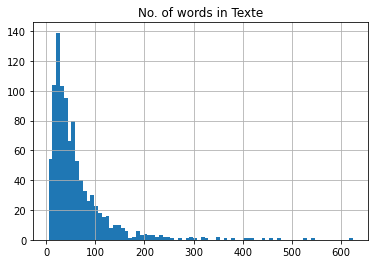

In [22]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qText'].hist(bins=80)
plt.title("No. of words in Texte")

## La plupart des titres ont environ 7 mots tandis que pour Body, il se situe autour de 50. Donc, pour obtenir les questions les plus similaires, nous allons utiliser le Title au lieu de Body.

## Word Cloud

In [43]:
def getWordCloud(df,col):
    comment_words = ''
    stopwords = set(STOPWORDS)
    stopwords.add('nan')
    stopwords.add('use')
    stopwords.add('way')
    stopwords.add('one')

    for val in tqdm(df[col]):

        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

  0%|          | 0/990 [00:00<?, ?it/s]

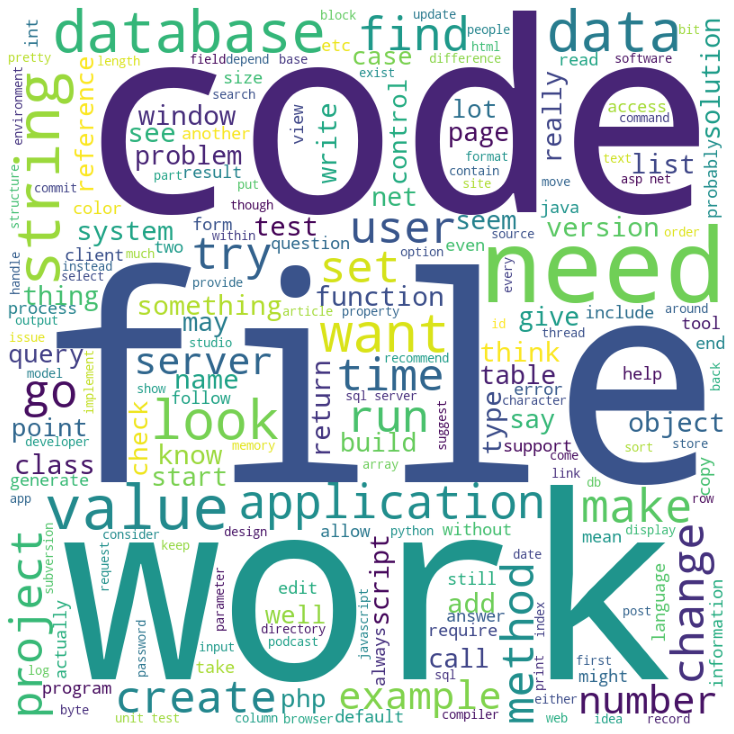

In [46]:
getWordCloud(df_questions,'Text')

## Prétraitement du titre - Suppression des mots vides, des caractères non alphanumériques et de tous les caractères en minuscules.

In [57]:
stop = stopwords.words('english')
def preprocess(df, col):
    df['preprocessed'+col] = df[col].apply(lambda x : " ".join([word for word in x.split(" ") if word not in stop]))
    df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')
    df['preprocessed'+col] = df['preprocessed'+col].str.lower()
    return df

In [58]:
questions = preprocess(questions, 'Title')

<ipython-input-57-9fa6568cbb61>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')


## Tags

In [59]:
tags = pd.read_csv("input/Tags.csv", encoding = "ISO-8859-1")
print(len(tags))
display(tags.head(5))

1885078


,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [60]:
print("Nombre de tags uniques : ", tags['Tag'].nunique())

Number of unique Tags :  16895


20 Tags les plus fréquents Sauf Python qui est évidemment le plus fréquent.

<AxesSubplot:>

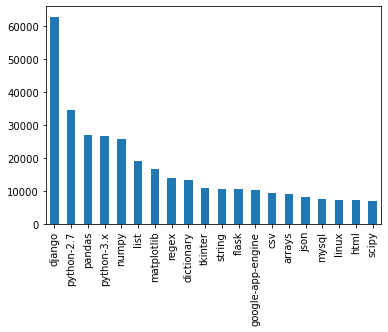

In [91]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('w')
tags[tags['Tag']!='python']['Tag'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')

## Encoding the Processed Question Title and Embedding it using GPT2 Tokenizer. 

In [62]:
config_class, model_class, tokenizer_class = GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
model = model_class.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [63]:
preprocessedTitle = questions['preprocessedTitle'].values
QID = questions['Id'].values
print(len(preprocessedTitle), len(QID))

607282 607282


Utilisation de tokenizer.batch_encode_plus pour encoder tous les titres en une seule fois. Au lieu de tokenizer.batch_encode_plus, tokenizer.encode peut être utilisé pour encoder 1 instance à la fois

In [74]:
encodedpreprocessedTitle = tokenizer.batch_encode_plus(preprocessedTitle)['input_ids']
print(len(encodedpreprocessedTitle))

607282


Chargement de l’embedding à partir du modèle GPT2. Chaque token dans la "embedding matrix”  est un vecteur de longueur 768 et l’embedding a 50257 uniques tokens.

In [75]:
embeddigs = model.transformer.wte
print("Shape de l' embedding matrix : ",embeddigs.weight.shape)
print("Type de l' embedding matrix : ", type(embeddigs))

Shape of embedding matrix :  torch.Size([50257, 768])
Type of embedding matrix :  <class 'torch.nn.modules.sparse.Embedding'>


## Dans le code ci-dessous, Nous avons pris la moyenne à travers des embeddings de tous les tokens dans un titre particulier. Ainsi, après avoir pris la moyenne, chaque titre serait représenté par un vecteur de longueur 768. Et la même chose a été faite pour tous les 607282 titres dans une boucle for.
## Remarque - Il peut y avoir des cas où le nombre de jetons dans le titre traité peut être égal à 0, d'où la condition de len (encodedTitle)> 0 a été appliquée.

In [76]:
TitleEmbeddingList = []
QIDList = []
for idx, (qid, encodedTitle) in tqdm(enumerate(zip(QID, encodedpreprocessedTitle))):
    if len(encodedTitle) > 0 :
        embeddedTitle = embeddigs(torch.tensor(encodedTitle).to(torch.int64)).mean(axis=0)
        TitleEmbeddingList.append(embeddedTitle)
        QIDList.append(qid)

0it [00:00, ?it/s]

In [77]:
numQ = len(TitleEmbeddingList)
embedDim = len(TitleEmbeddingList[0])
print("Nombre de Titres : ",numQ," et longueur du vecteur de chaque titre : ",embedDim)

Number of Titles :  607281  and Length of vector of each Title :  768


In [78]:
print("Type de TitleEmbeddingList : ",type(TitleEmbeddingList))

Type of TitleEmbeddingList :  <class 'list'>


## Conversion de TitleEmbeddingList de "liste de tenseurs" en tenseur.

In [83]:
TitleEmbeddingTensor = torch.cat(TitleEmbeddingList, dim=0)
TitleEmbeddingTensor = torch.reshape(TitleEmbeddingTensor, (numQ, embedDim))
print("Shape de TitleEmbeddingTensor : ",TitleEmbeddingTensor.shape)
print("Type de TitleEmbeddingTensor : ", type(TitleEmbeddingTensor))

Shape of TitleEmbeddingTensor :  torch.Size([607281, 768])
Type of TitleEmbeddingTensor :  <class 'torch.Tensor'>


# Une fois que nous avons créé la représentation avec l’embedding pour chaque titre. Nous allons maintenant entrer une question et rechercher parmi les titres de question StackOverflow lesquels sont les plus similaires à l'entrée en utilisant la similitude cosinus entre l’embedding de la question d'entrée et les titres.

## PreProcess du texte des titres

In [84]:
def preprocesstext(text):
    text =  " ".join([word for word in text.split(" ") if word not in stop])
    text = re.sub(r'[^a-zA-Z0-9 ]','',text)
    text = text.lower()
    return text

## Effectuer une similarité cosinus entre la question entrée et tous les titres StackOverFlow et obtenir l'index des titres K les plus similaires

In [85]:
def getMostSimilarQuestionsIdx(K, a, b):
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    res = torch.mm(a_norm, b_norm.transpose(0,1)).squeeze(0)
    res = res.tolist()
    mostSimIdx = sorted(range(len(res)), key=lambda x: res[x])[-K:]
    return mostSimIdx

## Afficher les titres de questions les plus similaires avec l'ID de question et les tags associés

In [141]:
def getMostSimilarQuestions(K, input, QuestionDF, QIDList, Tags):
    input = input
    preprocessedinput = preprocesstext(input)
    inputEncoded = tokenizer.batch_encode_plus([preprocessedinput])['input_ids']
    inputEmbedded = embeddigs(torch.tensor(inputEncoded).to(torch.int64)).squeeze(0).mean(axis=0).unsqueeze(0)
    mostSimilarIdx = getMostSimilarQuestionsIdx(K, inputEmbedded, TitleEmbeddingTensor)
    mostSimilarIdx.reverse()
    print("Most similar ",K, " questions : ",'\n')
    for idx, simidx in enumerate(mostSimilarIdx):
        IDQ = QuestionDF[QuestionDF['Id']==QIDList[simidx]][['Id','Title']].values
        parentId = IDQ[0][0]
        simQuestion = IDQ[0][1]
        print((idx+1), "Question Id : ", parentId, "\n", "Question : ",simQuestion)
        similar_tags = Tags[Tags['Id']==QIDList[simidx]][['Tag']].values
        tags_list =  " , ".join([word for word in similar_tags[:,0]])
        print("Tags suggérés : ", tags_list, "\n")

## Test

In [142]:
tag_list=getMostSimilarQuestions(5, "How to MUltiply 2 columns pandas ?", questions ,QIDList, tags)

Most similar  5  questions :  

1 Question Id :  29229892 
 Question :  How can I multiply each column with the other columns of the Pandas DataFrame?
Tags suggérés :  python , pandas 

2 Question Id :  30224626 
 Question :  How can I join columns in Pandas?
Tags suggérés :  python , pandas 

3 Question Id :  37929109 
 Question :  How to merge / overwrite columns in Pandas
Tags suggérés :  python , pandas 

4 Question Id :  38026984 
 Question :  How do I calculate a pandas column with multiple columns as arguments?
Tags suggérés :  python , pandas 

5 Question Id :  19221694 
 Question :  How many columns in pandas, python?
Tags suggérés :  python , pandas 



In [143]:
getMostSimilarQuestions(5, "regex pandas", questions ,QIDList, tags)

Most similar  5  questions :  

1 Question Id :  34375898 
 Question :  REGEX using Pandas
Tags suggérés :  python , regex , pandas 

2 Question Id :  39125455 
 Question :  Regex with columns pandas
Tags suggérés :  python , regex , pandas , dataframe , series 

3 Question Id :  36360828 
 Question :  Regex Difficulties Extracting Text for Pandas Dataframe
Tags suggérés :  python , regex , pandas 

4 Question Id :  31271146 
 Question :  In Pandas module of python pandas.read_excel is not working
Tags suggérés :  python , python-2.7 

5 Question Id :  38336727 
 Question :  regex and python
Tags suggérés :  python , regex 



In [144]:
getMostSimilarQuestions(5, "logistic regression sklearn", questions ,QIDList, tags)

Most similar  5  questions :  

1 Question Id :  32724678 
 Question :  Logistic Regression with sklearn
Tags suggérés :  python , scikit-learn , classification , logistic-regression 

2 Question Id :  40067172 
 Question :  Logistic Regression model on sklearn
Tags suggérés :  python , machine-learning , scikit-learn 

3 Question Id :  24935415 
 Question :  Logistic Regression function on sklearn
Tags suggérés :  python , numpy , machine-learning , scipy , scikit-learn 

4 Question Id :  20869711 
 Question :  Features in sklearn logistic regression
Tags suggérés :  python , machine-learning , nlp , logistic-regression , scikit-learn 

5 Question Id :  34033189 
 Question :  sklearn Python and Logistic regression
Tags suggérés :  python , scikit-learn , logistic-regression 



In [145]:
getMostSimilarQuestions(5, "covert csv to json file pandas", questions ,QIDList, tags)

Most similar  5  questions :  

1 Question Id :  23057219 
 Question :  how to convert csv to dictionary using pandas
Tags suggérés :  python , csv , dictionary , pandas 

2 Question Id :  30132999 
 Question :  convert whole csv to json file- python
Tags suggérés :  python , json , csv , geojson 

3 Question Id :  23231605 
 Question :  Convert Pandas dataframe to csv string
Tags suggérés :  python , pandas 

4 Question Id :  35515367 
 Question :  Convert a single string formatted as a csv file into a pandas dataframe
Tags suggérés :  python , csv , pandas , dataframe 

5 Question Id :  38291701 
 Question :  Using pandas over csv library for manipulating CSV files in Python3
Tags suggérés :  python , csv 



In [146]:
getMostSimilarQuestions(5, "Build website using python", questions ,QIDList, tags)

Most similar  5  questions :  

1 Question Id :  4828238 
 Question :  Connect to a website using Python
Tags suggérés :  python 

2 Question Id :  34830638 
 Question :  Build a URL using Python requests library
Tags suggérés :  python , url , python-requests 

3 Question Id :  23691606 
 Question :  Build a URL using Requests module Python
Tags suggérés :  python , python-requests 

4 Question Id :  31333864 
 Question :  login into a website using python
Tags suggérés :  php , python 

5 Question Id :  14424858 
 Question :  how to login into a website using python
Tags suggérés :  python 



In [147]:
getMostSimilarQuestions(5, "How to install Pandas", questions ,QIDList, tags)

Most similar  5  questions :  

1 Question Id :  31211853 
 Question :  How to install Python Pandas?
Tags suggérés :  python , osx , numpy , pandas , packages 

2 Question Id :  38768996 
 Question :  How to install pandas for Python 3?
Tags suggérés :  python , pandas , install , pip , python-3.4 

3 Question Id :  22924370 
 Question :  How to make this pandas query?
Tags suggérés :  python , pandas , dataframe 

4 Question Id :  28560826 
 Question :  How do I install pandas for Python 3.4 in Windows?
Tags suggérés :  python , numpy , pandas 

5 Question Id :  39286344 
 Question :  How to use merge in pandas
Tags suggérés :  python , pandas 

